<a target="_blank" href="https://colab.research.google.com/github/pywavelet/pywavelet/blob/main/docs/examples/lisa_sprint.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

# Lisa Sprint 

WDM transform in JAX, trying to follow Neil's paper as closely as possible.

Running JAX on cpu


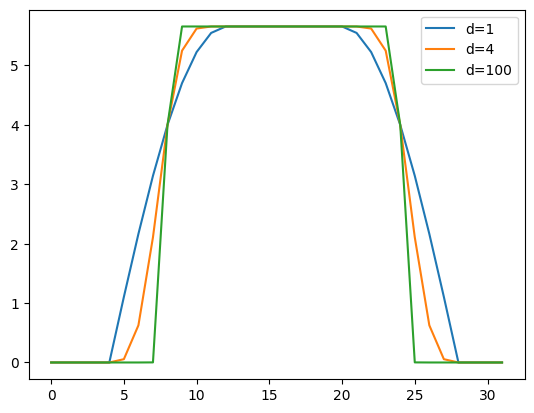

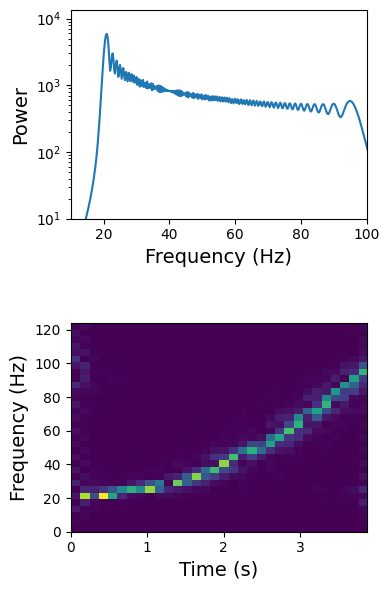

In [1]:
import numpy as np
from scipy.special import betainc
from scipy.signal import chirp
import jax
import matplotlib.pyplot as plt
import jax.numpy as jnp
from matplotlib.colors import TwoSlopeNorm
import glob
import os
from PIL import Image

jax.config.update("jax_enable_x64", True)

DEVICE = jax.devices()[0].device_kind
print(f"Running JAX on {DEVICE}")

PI = np.pi
FREQ_RANGE = [20, 100]


def omega(Nf: int, Nt: int):
    df = 2 * np.pi / (Nf * Nt)
    return df * np.arange(-Nt // 2, Nt // 2, dtype=np.float64)


def phitilde_vec_norm(Nf: int, Nt: int, d: float):
    return _phitilde_vec(omega(Nf, Nt), Nf, d) * np.sqrt(np.pi)


def phi_vec(Nf: int, d: float = 4.0, q: int = 16):
    """get time domain phi as fourier transform of _phitilde_vec
    q: number of Nf bins over which the window extends?
    """
    insDOM = 1.0 / np.sqrt(np.pi / Nf)
    K = q * 2 * Nf
    half_K = q * Nf  # xp.int64(K/2)

    dom = 2 * np.pi / K  # max frequency is K/2*dom = pi/dt = OM
    DX = np.zeros(K, dtype=np.complex128)

    # zero frequency
    DX[0] = insDOM

    DX = DX.copy()
    # postive frequencies
    DX[1 : half_K + 1] = _phitilde_vec(dom * np.arange(1, half_K + 1), Nf, d)
    # negative frequencies
    DX[half_K + 1 :] = _phitilde_vec(
        -dom * np.arange(half_K - 1, 0, -1), Nf, d
    )
    DX = K * np.fft.ifft(DX, K)

    phi = np.zeros(K)
    phi[0:half_K] = np.real(DX[half_K:K])
    phi[half_K:] = np.real(DX[0:half_K])

    nrm = np.sqrt(2.0) / np.sqrt(K / dom)  # *xp.linalg.norm(phi)

    phi *= nrm
    return np.array(phi)


def _phitilde_vec(omega, Nf: int, d: float = 4.0):
    """Compute phi_tilde(omega_i) array, nx is filter steepness, defaults to 4.
    Eq 11 of Cornish '20
    """
    dF = 1.0 / (2 * Nf)  # NOTE: missing 1/dt?
    dOmega = 2 * np.pi * dF  # Near Eq 10 # 2 pi times DF
    inverse_sqrt_dOmega = 1.0 / np.sqrt(dOmega)

    A = dOmega / 4
    B = dOmega - 2 * A  # Cannot have B \leq 0.
    if B <= 0:
        raise ValueError("B must be greater than 0")

    phi = np.zeros(omega.size, dtype=np.float64)
    mask = (A <= np.abs(omega)) & (np.abs(omega) < A + B)
    vd = (np.pi / 2.0) * betainc(d, d, (np.abs(omega)[mask] - A) / B)
    phi[mask] = inverse_sqrt_dOmega * np.cos(vd)
    phi[np.abs(omega) < A] = inverse_sqrt_dOmega
    return phi


def xtilde_i(
    m: int, data: jnp.ndarray, Nf: int, Nt: int, phif: jnp.ndarray
) -> jnp.ndarray:
    # i0 = data.shape[0] // 2 + 1
    # i0 is the center of the data -- used
    i0 = (Nt * Nf) // 2 + 1
    j0 = i0 - (Nt // 2)
    j1 = i0 + (Nt // 2)
    xni = jnp.fft.ifft(jnp.roll(data, -(m * Nt // 2))[j0:j1] * phif)
    return xni


def Cnm_matrix(Nf: int, Nt: int) -> jnp.ndarray:
    i_inds = jnp.arange(Nf)
    j_inds = jnp.arange(Nt)

    ij = i_inds[:, None] + j_inds[None, :]
    ij_prod = i_inds[:, None] * j_inds[None, :]

    sign_matrix = jnp.where(ij_prod % 2 == 0, 1, -1)

    return jnp.where(ij % 2 == 0, 1, 1j) * sign_matrix


def freq_to_wdm(
    data: jnp.ndarray, Nf: int, Nt: int, phif: jnp.ndarray
) -> jnp.ndarray:
    # fftshifft data to match up with Neil Eq 17
    data_shifted = jnp.fft.fftshift(data)
    output = jnp.zeros((Nf, Nt), dtype=jnp.complex128)

    # v1 = [xtilde_i(i, data_shifted, Nf, Nt, phif) for i in range(Nt)]

    return (
        jax.lax.fori_loop(
            0,
            Nt,
            lambda i, output: output.at[:, i].set(
                xtilde_i(i, data_shifted, Nf, Nt, phif)
            ),
            output,
        )
        * Cnm_matrix(Nf, Nt)
    ).real * jnp.sqrt(2.0)


Nf = 32
Nt = Nf
nx = 4.0

assert Nf & (Nf - 1) == 0, "Nf must be a power of 2"
fs = 256
dt = 1 / fs
mult = 16
nx = 1
ND = Nt * Nf
t = np.arange(0, ND) * dt
f = np.fft.rfftfreq(ND, dt)
T = ND * dt
y = chirp(t, f0=FREQ_RANGE[0], f1=FREQ_RANGE[1], t1=t[-1], method="quadratic")
phif = jnp.array(phitilde_vec_norm(Nf, Nt, d=nx))
phit = phi_vec(Nf, d=nx)
yf = jnp.fft.fft(y)

# wave = transform_wavelet_freq_helper_numba(yf, Nf, Nt, phif)
yf = jnp.array(yf)
jax_phif = jnp.array(phif)

plt.plot(phitilde_vec_norm(Nf, Nt, d=1), label="d=1")
plt.plot(phitilde_vec_norm(Nf, Nt, d=4), label="d=4")
plt.plot(phitilde_vec_norm(Nf, Nt, d=100), label="d=100")
plt.legend()
plt.show()

wave = freq_to_wdm(yf, Nf, Nt, jax_phif)
delta_T = T / Nt
delta_F = 1 / (2 * delta_T)
t_bins = np.arange(0, Nt) * delta_T
f_bins = np.arange(0, Nf) * delta_F

fig, axes = plt.subplots(2, 1, figsize=(4, 6))
axes[0].semilogy(f, (np.abs(yf) ** 2)[: ND // 2 + 1], label="FFT")
axes[0].set_xlabel("Frequency (Hz)", fontsize=14)
axes[0].set_ylabel("Power", fontsize=14)
axes[0].set_xlim(10, 100)
axes[0].set_ylim(bottom=10)

im = axes[1].imshow(
    np.abs((wave.T)),
    aspect="auto",
    extent=[t_bins[0], t_bins[-1], f_bins[0], f_bins[-1]],
    origin="lower",
    interpolation="nearest",
)
axes[1].set_xlabel("Time (s)", fontsize=14)
axes[1].set_ylabel("Frequency (Hz)", fontsize=14)
plt.tight_layout()

fig.subplots_adjust(hspace=0.5)
plt.show()


#
#
# def gnm_matrix(omega, Nf, Nt, A, B, d):
#     """
#     g˜nm(ω) = e −inω∆T (CnmΦ(ω − m∆Ω)+C∗nmΦ(ω + m∆Ω))
#
#
#     2A+B = ∆Ω
#     """
#
#
#     cnm = Cnm_matrix(Nf, Nt)
#     cnmconj = jnp.conjugate(cnm)
#
#
#
#     v1 = jnp.exp(-1j * omega[:, None] * jnp.arange(Nt) / Nf)
#
#     phi =
#
#
#     return  v1 * cnm * ph +

#
# def gnm(Cnm, CnmConj, A, B, d):  ### Eq 10
#     """
#     gnm(ω) = e −inω∆T (CnmΦ(ω − m∆Ω)+C∗nmΦ(ω + m∆Ω))
#     2A+B = ∆Ω
#     """
#
#     # omega = jnp.fft.fftshift(omega)
#     # omega = jnp.roll(omega, -Nf // 2)
#     # omega = jnp.fft.ifftshift(omega)
#
#      _phitilde_vec(omegas, Nf, d) * np.sqrt(np.pi)
#
#     return v1 * Cnm * ph + v1 * CnmConj * ph


#
# def


# wave2 = freq_to_wdm(yf, Nf, Nt, jax_phif)

## Animation

In [ ]:
import os

plt_dir = "wdm_plots"
# make
os.makedirs(plt_dir, exist_ok=True)

f = np.fft.fftfreq(ND, dt)
f = np.fft.fftshift(f)
d = jnp.fft.fftshift(yf)
output = jnp.zeros((Nf, Nt), dtype=jnp.complex128)
i0 = (Nt * Nf) // 2 + 1
j0 = i0 - (Nt // 2)
j1 = i0 + (Nt // 2)
min_wnm, max_wnm = np.min(wave), np.max(wave)

for m in range(Nt):
    rolled_d = jnp.roll(d, -(m * Nt // 2))
    xni = jnp.fft.ifft(rolled_d[j0:j1] * phif)

    fig = plt.figure(figsize=(5, 6))
    gs = fig.add_gridspec(2, 2)

    ax1 = fig.add_subplot(gs[0, 0])
    ax2 = fig.add_subplot(gs[0, 1])
    ax3 = fig.add_subplot(gs[1, :])

    ax1.plot(f, np.abs(d) ** 2, color="tab:gray", alpha=0.2)
    ax1.plot(f, np.abs(rolled_d) ** 2, color="tab:gray", label="Roll(y)")
    ax1.fill_between(
        np.arange(-Nt // 2, Nt / 2),
        max(np.abs(d) ** 2) * phif / max(phif),
        alpha=0.5,
        color="tab:orange",
        label="Window",
    )
    ax1.legend(loc="upper left", frameon=False)
    ax1.set_ylim(bottom=0)
    ax2.plot(t_bins, xni)
    ax2.set_ylim(min_wnm, max_wnm)

    ax1.set_xlabel("Freq [Hz]")
    ax1.set_ylabel("Power")

    ax2.set_xlabel("Time [s]")
    ax2.set_ylabel("Wnm")

    wdm_m = np.array(wave)
    wdm_m[:, m + 1 :] = 0
    # cmap of 'bwr' with vcenter=0

    curr_min = min(wdm_m.min(), -1)
    curr_max = max(wdm_m.max(), 1)

    norm = TwoSlopeNorm(0, curr_min, curr_max)
    im = ax3.imshow(
        wdm_m.T,
        aspect="auto",
        extent=[t_bins[0], t_bins[-1], f_bins[0], f_bins[-1]],
        origin="lower",
        interpolation="nearest",
        norm=norm,
        cmap="bwr",
    )
    ax3.set_xlabel("Time [s]", fontsize=14)
    ax3.set_ylabel("Freq [Hz]", fontsize=14)
    # add colorbar and label it Wnm
    cbar = fig.colorbar(im, ax=ax3)
    cbar.set_label("Wnm", fontsize=14)
    plt.tight_layout()
    plt.savefig(f"{plt_dir}/wdm_{m:02d}.png")


def make_gif_from_images(image_dir, gif_name, duration=3):
    images = []
    files = glob.glob(os.path.join(image_dir, "*.png"))
    files = sorted(
        files,
        key=lambda x: int(os.path.basename(x).split("_")[1].split(".")[0]),
    )
    for filename in files:
        images.append(Image.open(filename))
    images[0].save(
        gif_name,
        save_all=True,
        append_images=images[1:],
        duration=duration * 1000,  # Convert seconds to milliseconds
        loop=0,
    )


make_gif_from_images(plt_dir, "wdm.gif", duration=0.5)